## Imports

In [22]:
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import inception_resnet_v2
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle

## Load Data

In [2]:
# Data from google colab
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#Import from local repository

data = image_dataset_from_directory("/Users/cristobalmorano/code/nadiasalmen/waiste/data/waistedata", 
                             labels='inferred', label_mode='categorical', class_names=None, color_mode='rgb',
                             batch_size=32, image_size=(128, 128), shuffle=True, seed=None,
                             validation_split=None, subset=None, interpolation='bilinear', follow_links=False,
                             crop_to_aspect_ratio=False)

Found 22610 files belonging to 10 classes.


2021-09-26 23:20:55.141481: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Take number of images according to batch size

data_sample = data.take(700)

data_im = []
data_lb = []

for im, lb in data_sample:
    data_im.append(im)
    data_lb.append(lb)

2021-09-26 23:20:58.042901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-26 23:21:25.299180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-09-26 23:22:55.165376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [5]:
#Normalize image tensors (0 - 1)

def norma_2(image):
    image = tf.cast(image/255, tf.float32)
    return image

data_im_2 = [norma_2(image) for image in data_im]

In [6]:
#Convert X and y to numpy arrays

data_im_2 = np.array(data_im_2)
data_lb = np.array(data_lb)

In [7]:
#Reshape for model

data_im_2 = data_im_2.reshape(-1, 128, 128, 3)
data_lb = data_lb.reshape(-1, 10)

In [8]:
# Split the data

train_X, test_X, train_y, test_y = train_test_split(data_im_2, data_lb, test_size=0.2, random_state=42)

## Build model

In [9]:
#Import InceptionResNetV2

inception_resnet_v2 = inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                                            weights="imagenet", input_tensor=None, 
                                                            input_shape=(128, 128, 3), pooling=None, 
                                                            classifier_activation='softmax')

In [10]:
inception_resnet_v2.trainable = False

In [11]:
def init_model():
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))
    
    model.add(inception_resnet_v2)
    
    model.add(Conv2D(32, (4,4), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(4,4), padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(3,3), padding='same'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(16, (2,2), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [12]:
model = init_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 2, 2, 32)          786464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 1, 1, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0

In [14]:
es = EarlyStopping(patience = 40, monitor='val_loss' , min_delta=0.001, restore_best_weights = True)

In [15]:
history = model.fit(train_X, train_y, validation_split = 0.3, 
                    callbacks = [es], batch_size = 64, 
                    epochs = 500, verbose = 1)

Epoch 1/500
196/196 [==============================] - 464s 2s/step - loss: 1.7020 - accuracy: 0.3922 - val_loss: 1.2229 - val_accuracy: 0.6142
Epoch 2/500
196/196 [==============================] - 439s 2s/step - loss: 1.2784 - accuracy: 0.5729 - val_loss: 1.0471 - val_accuracy: 0.6747
Epoch 3/500
196/196 [==============================] - 436s 2s/step - loss: 1.1496 - accuracy: 0.6182 - val_loss: 1.0141 - val_accuracy: 0.6782
Epoch 4/500
196/196 [==============================] - 443s 2s/step - loss: 1.0847 - accuracy: 0.6402 - val_loss: 0.9515 - val_accuracy: 0.6966
Epoch 5/500
196/196 [==============================] - 442s 2s/step - loss: 1.0064 - accuracy: 0.6651 - val_loss: 0.9084 - val_accuracy: 0.7057
Epoch 6/500
196/196 [==============================] - 441s 2s/step - loss: 0.9791 - accuracy: 0.6707 - val_loss: 0.9520 - val_accuracy: 0.7087
Epoch 7/500
196/196 [==============================] - 441s 2s/step - loss: 0.9286 - accuracy: 0.6967 - val_loss: 0.9118 - val_accuracy:

In [18]:
def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10, 15))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()

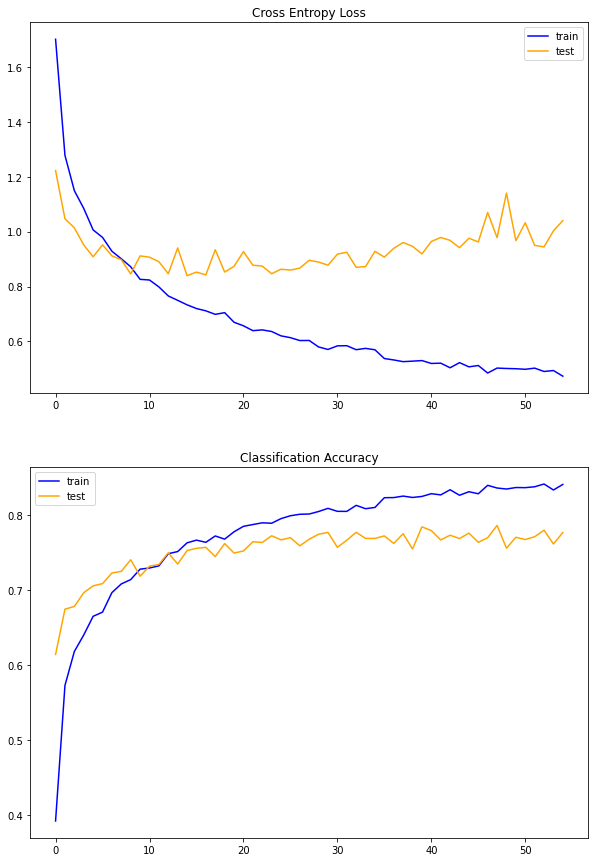

In [19]:
summarize_diagnostics(history)

In [27]:
scores = model.evaluate(test_X, test_y, verbose=1)

140/140 [==============================] - 120s 831ms/step - loss: 0.8248 - accuracy: 0.7652


In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("model_acc_076.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

AttributeError: Can't pickle local object 'inception_resnet_block.<locals>.<lambda>'